In [1]:
import numpy as np
import math
import scipy
from matplotlib import pyplot as plt
%pylab inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=23)

Populating the interactive namespace from numpy and matplotlib


The goal of this code is to simulate an evolution of barcoded lineages in dynamical environments, in the context of serial transfers. Here, dynamical environments are represented by sequences of block of environments of different cumulative time: for example 8 generations in environment_1, then 32 in environment_2, then 144 in environment_3 and finally 16 generations in environment_1.

It is a simplified model where only the most represented clone in a lineage can feed mutants to the lineage, making the algorithm more traceable/interpretable. Even if it is simplified, the model still encompasses the major characteristics of barcoded lineage evolution done in serial transfers. 

Here are the parameters you will need to provide to do the simulation:
- The probability that a mutated lineage fitness will be beneficial in the next environment
- The probability that a mutated lineage fitness will be deleterious in the next environment
- A sequence of number of passage (serial transfer) is each block of environment.
- A sequence of high bound for your DFE (Distribution of fitness effect) in the different blocks of environment
- A sequence of low bound for your DFE in the different blocks of environment
- A sequence of mutation rate in each block of environment
- The address for the output files
- A scale parameter in the case you want your DFE to be more complicated than a simple uniform distribution

Some parameters are hardcoded since they define the experiment outside of the evolution in the environment dynamics that you explore: like the dilution ratio, the total size of the population at saturation, the barcode library diversity, or the mutation rate inherent to the library making.

The outputs are 4 files per block of environment which all have a header (except final.txt) standing for the time points:
- one file env.txt: order with BC (barcode) giving the count of each lineage at each time point within one block of environment, after the bottleneck
- one file full.txt: order with BC giving the count of each lineage at each time point within one block of environment, before the bottleneck.
- one file final.txt:  a lineage is within two '@', the first line is the count of a particular mutant in the lineage at the end of the environment block, the second line is the fitness of this particular mutant and the third line is the generation at which it appeared. Each column is a particular mutant that arise in this lineage during that environment block.
- one file all.txt: a lineage is within two '@', this time each line between two '@' corresponds to a time point and the first entry on this line is the size of this lineage at that time point and each column is the count of a specific mutant in this lineage at that time point.

For more information SI : https://www.biorxiv.org/content/10.1101/724419v1

$\textbf{Some examples of the outcome of this simulation code are displayed at the end of this notebook.}$

### Hardcoded parameters

In [2]:
barcode=np.arange(500000) #barcode diversity
epsilon=60.0/(5*10**6) #mutation rate during library making
bottle_neck_size=5*10**7 # the size of the population you transfer in your serial transfer experiment
gen=8 #passage time in generation

N_s=1.3*10**10 #saturation size of your population

bottle=256 #dilution = ratio 1./bottle



### Hardcoded DFE

In [3]:
def fitnesseur(scale,low,high):
    x=np.random.exponential(scale)#put whatever fitness function you want. Here I've chosen an exponential DFE
    while x>=high or x<=low:
         x=np.random.exponential(scale)#put whatever fitness function you want
    return x

### Main code

In [4]:
def simulateur(P_b,P_d,sequence_time_points,sequence_low,sequence_high,sequence_mut_rate,adresse1,scale_p):
    ####################################################################################
    #Setting up how environment "talks" together : probability that a mutant will become beneficial,deleterious or neutral on next environment
    initial_list=list()
    #P_b=radius*np.cos(angle)**2 #that was jsut a cool trick for autmomatization of those parameters in a serial use of this simulation
    #P_d=radius*np.sin(angle)**2
    P_n=1-P_d-P_b
    ordered=sorted([P_b,P_d,P_n])
    P_b_k=0
    for i in range(3):
        if ordered[i]==P_b:
            P_b_k=i
            break
    P_d_k=0
    for i in range(3):
        if ordered[i]==P_d:
            P_d_k=i
            break
    P_n_k=0
    for i in range(3):
        if ordered[i]==P_n:
            P_n_k=i
            break
    print('P_b_k='+str(P_b_k)+','+'P_d_k='+str(P_d_k)+','+'P_n_k='+str(P_n_k))
    print('P_b='+str(P_b)+','+'P_d='+str(P_d)+','+'P_n='+str(P_n))
    mut_rate=sequence_mut_rate[0]
    low=sequence_low[0]
    high=sequence_high[0]
    #print(mut_rate)
    #print(low)
    #print(high)
    dico_signe={P_b_k:1,P_d_k:-1,P_n_k:0}
    ####################################################################################
    #initialization of the library and first step of evolution due to platting and regrowing of library when it is made
    adresse=adresse1+'_'+str(P_b)+'_'+str(P_d)
    pop_initial=[{bc:[[np.random.poisson(10)],[0],[0]] for bc in barcode}]#initial lineage size is centered around 10
    summ=0
    for bc in barcode:
        mut=np.random.poisson(pop_initial[0][bc][0][0]*epsilon)
        if mut!=0:
            pop_initial[0][bc][1][0]=np.random.uniform(low,high)
            summ+=pop_initial[0][bc][0][0]


    for i in range(16):#How many generation things evolved before the start of the actual experiment (genetic standing variation)
        for bc in barcode:
            for j in range(1,len(pop_initial[0][bc][1])):
                pop_initial[0][bc][0][j]=np.random.poisson(pop_initial[0][bc][0][j]*2*(1))
            add=pop_initial[0][bc][0][0]
            pop_initial[0][bc][0][0]=np.random.poisson(pop_initial[0][bc][0][0]*2*(1))#increasing lineage size by one more generation
            if pop_initial[0][bc][0][0]-add>0:
                mut=np.random.poisson((pop_initial[0][bc][0][0]-add)*mut_rate)#number of mutant is the lineage
            else:
                mut=0
            if mut!=0:#getting the fitness associated to those mutant
                pop_initial[0][bc][0]+=[1 for u in range(mut)]
                pop_initial[0][bc][1]+=[np.random.uniform(low,high) for u in range(mut)]
                pop_initial[0][bc][2]+=[0 for u in range(mut)]


    toutou=sum([sum(pop_initial[0][bc][0]) for bc in barcode])
    for bc in barcode:#scaling down to the carrying capacity
        for j in range(len(pop_initial[0][bc][0])):
            pop_initial[0][bc][0][j]=np.random.poisson(pop_initial[0][bc][0][j]/toutou*N_s)

    toutou=sum([sum(pop_initial[0][bc][0]) for bc in barcode])
    pop=pop_initial+[{bc:[[0],[0],[0]] for bc in barcode} for i in range(sequence_time_points[0])]
    random.seed()
    tot=toutou
    ##################################################################################################
    #Starting evolution
    for t in range(len(sequence_time_points)):
        print('This is t '+str(t))
        time_points=sequence_time_points[t]
        low=sequence_low[t]
        high=sequence_high[t]
        mut_rate=sequence_mut_rate[t]
        
        for k in range(1,len(pop)):
            print(k)
            for bc in barcode:
                glam=list()
                for v in range(len(pop[k-1][bc][0])):
                    glam.append(np.random.binomial(int(pop[k-1][bc][0][v]*N_s/tot),1./bottle))#scalling for bottleneck passage

                pop[k][bc][0]=glam
                pop[k][bc][1]=list(pop[k-1][bc][1])
                pop[k][bc][2]=list(pop[k-1][bc][2])
                
                s=list()
                est_list=list()
                keep_mut=0
                for i in range(gen):
                    for v in range(1,len(pop[k][bc][1])):
                        pop[k][bc][0][v]=np.random.poisson(2*(pop[k][bc][1][v]+1)*pop[k][bc][0][v])

                    pop[k][bc][0][0]=np.random.poisson(2*(pop[k][bc][1][0]+1)*pop[k][bc][0][0])
                    mut=np.random.poisson((mut_rate)*(pop[k][bc][0][0]))#number of mutants
                    keep_mut+=mut
                    for u in range(int(mut)):
                        ga=fitnesseur(scale_p[t],low,high)#fitness associated to those mutants
                        s.append(pop[k][bc][1][0]+ga)
                        est_list.append(int(gen*(k-1)+i+1+sum(sequence_time_points[0:t])*gen))
                gamma=len(pop[k][bc][1])
            
                if keep_mut!=0:
                    pop[k][bc][0]=pop[k][bc][0]+[1 for y in range(int(keep_mut))]
                    pop[k][bc][1]=pop[k][bc][1]+s
                    pop[k][bc][2]=pop[k][bc][2]+est_list
                for v in range(gamma,len(pop[k][bc][1])):
                    tiff=gen*k-pop[k][bc][2][v]
                    for i in range(tiff):
                        pop[k][bc][0][v]=np.random.poisson(2*(pop[k][bc][1][v]+1)*pop[k][bc][0][v])#next generation lineage size
            tot=sum([sum(pop[k][bc][0]) for bc in barcode])
            print(tot)
            for bc in barcode:
                glam=list()
                for v in range(len(pop[k][bc][0])):
                    glam.append(np.random.poisson((pop[k][bc][0][v])*N_s/tot))#scalling to carying capacity
                pop[k][bc][0]=glam
            tot=sum([sum(pop[k][bc][0]) for bc in barcode])
            print(tot)
        f=open(adresse+'_'+str(t+1)+'.txt','w')
        plouf1=[w*gen for w in range(time_points+1)]
        plouf=list()
        for w in range(time_points+1):
            plouf.append(plouf1[w])
            plouf.append(plouf1[w])
        for k in range(len(plouf)):
            f.write(str(plouf[k])+'\t')
        f.write('\n')
        for bc in barcode:
            for k in range(len(pop)):
                f.write(str(np.random.poisson((sum(pop[k][bc][0])*1./(2*bottle))))+'\t')
                f.write(str(np.random.poisson((sum(pop[k][bc][0])*1./(2*bottle))))+'\t')
            f.write('\n')
        f.close()
        f=open(adresse+'_'+str(t+1)+'_final.txt','w')
        for bc in barcode:
            f.write('@'+'\n')
            for i in range(len(pop[time_points][bc][0])):
                f.write(str(pop[time_points][bc][0][i])+'\t')
            f.write('\n')
            for i in range(len(pop[time_points][bc][1])):
                f.write(str(pop[time_points][bc][1][i])+'\t')
            f.write('\n')
            for i in range(len(pop[time_points][bc][2])):
                f.write(str(pop[time_points][bc][2][i])+'\t')
            f.write('\n')
        f.close()
        f=open(adresse+'_'+str(t+1)+'_full.txt','w')
        for k in range(len(plouf)):
            f.write(str(plouf[k])+'\t')
        f.write('\n')
        for bc in barcode:
            for k in range(len(pop)):
                f.write(str(sum(pop[k][bc][0]))+'\t')
            f.write('\n')
        f.close()
        f=open(adresse+'_'+str(t+1)+'_all.txt','w')
        for k in range(len(plouf)):
            f.write(str(plouf[k])+'\t')
        f.write('\n')
        for bc in barcode:
            f.write('@'+'\n')
            for k in range(len(pop)):
                for j in range(len(pop[k][bc][0])):
                    f.write(str(pop[k][bc][0][j])+'\t')
                f.write('\n')
        f.close()
        f=open(adresse+'_'+str(t+1)+'_final.txt','r')
        lignes=f.readlines()
        adaptive=dict()
        plou=0
        for i in range(len(lignes)):
            if lignes[i][0]=='@':
                pop_str=lignes[i+1].split('\t')
                fit_str=lignes[i+2].split('\t')
                tau_str=lignes[i+3].split('\t')
                pop=[float(pop_str[i]) for i in range(len(pop_str)-1)]
                fit=[float(fit_str[i]) for i in range(len(fit_str)-1)]
                tau=[float(tau_str[i]) for i in range(len(tau_str)-1)]
                adaptive[plou]=[pop,fit,tau]
                plou+=1
        f.close()
        if t<len(sequence_low)-1:
            low=sequence_low[t]
            high=sequence_high[t]
            
            initial=dict()
            initial_list.append(initial)
            initial_pop={bc:[list(),list(),list()] for bc in barcode}
            initial_pop2={bc:[list(),list(),list()] for bc in barcode}
            
            if t>=1:# if second or more environment you need to store the different fitness associated to all mutants in a lineage 
                f=open(adresse+'_'+str(t)+'_env.txt','r').read()
                contenu=f.splitlines()
                initial2=dict()
                for i in range(len(contenu)):
                    bouya=contenu[i].split('\t')
                    initial2[(int(bouya[0]),int(bouya[1]))]=float(bouya[2])
                position={bc:list() for bc in adaptive.keys()}
                for bc in initial2.keys():
                    position[bc[0]].append(bc[1])
            gogo={bc:0 for bc in adaptive.keys()}
            for bc in adaptive.keys():
                maa=0
                maa=max(adaptive[bc][0])
                u=1
                for k in range(len(adaptive[bc][0])):
                    if adaptive[bc][0][k]==maa:
                        initial[(bc,0)]=adaptive[bc][1][k]
                        initial_pop2[bc][0].append(adaptive[bc][0][k])
                        initial_pop2[bc][1].append(adaptive[bc][1][k])
                        initial_pop2[bc][2].append(adaptive[bc][2][k])
                        gogo[bc]=k
                        break
                for k in range(len(adaptive[bc][0])):
                    if adaptive[bc][0][k]!=0:
                        
                        if k!=gogo[bc]:
                            initial[(bc,u)]=adaptive[bc][1][k]
                            u+=1
                    
                    if k!=gogo[bc]:
                        initial_pop2[bc][0].append(adaptive[bc][0][k])
                        initial_pop2[bc][1].append(adaptive[bc][1][k])
                        initial_pop2[bc][2].append(adaptive[bc][2][k])
                       
            f=open(adresse+'_'+str(t+1)+'_env.txt','w')
            for q in initial.keys():
                f.write(str(q[0])+'\t'+str(q[1])+'\t')
                f.write(str(initial[q])+'\n')
            f.close()
            for bc in adaptive.keys():
                if t==0: #The code is made such that only the highest clone in a lineage can exponentially feed mutants
                    low=sequence_low[1]
                    high=sequence_high[1]
                    for k in range(len(initial_pop2[bc][0])):
                        if sum(initial_pop2[bc][0])==0:
                            initial_pop[bc][1].append(initial_pop2[bc][1][0])
                            initial_pop[bc][0].append(initial_pop2[bc][0][0])
                            initial_pop[bc][2].append(initial_pop2[bc][2][0])
                        if initial_pop2[bc][2][k]==0 and initial_pop2[bc][1][k]==0 and initial_pop2[bc][0][k]!=0:
                            initial_pop[bc][1].append(initial_pop2[bc][1][k])
                            initial_pop[bc][0].append(initial_pop2[bc][0][k])
                            initial_pop[bc][2].append(initial_pop2[bc][2][k])
                        if initial_pop2[bc][2][k]!=0 and initial_pop2[bc][0][k]!=0:
                            combawa=np.random.uniform(0,1)
                            if combawa<ordered[0]:
                                plop=dico_signe[0]
                            if combawa<ordered[1]+ordered[0] and combawa>ordered[0]:
                                plop=dico_signe[1]
                            if combawa>ordered[1]+ordered[0] :
                                plop=dico_signe[2]
                            
                            
                            s_2=plop*fitnesseur(scale_p[1],low,high)
                            initial_pop[bc][1].append(s_2)
                            initial_pop[bc][0].append(initial_pop2[bc][0][k])
                            initial_pop[bc][2].append(initial_pop2[bc][2][k])
                        else:
                            if initial_pop2[bc][1][k]!=0 and initial_pop2[bc][0][k]!=0:
                                combawa=np.random.uniform(0,1)
                                if combawa<ordered[0]:
                                    plop=dico_signe[0]
                                if combawa<ordered[1]+ordered[0] and combawa>ordered[0]:
                                    plop=dico_signe[1]
                                if combawa>ordered[1]+ordered[0] :
                                    plop=dico_signe[2]
                                
                                
                                s_2=plop*fitnesseur(scale_p[1],low,high)
                                initial_pop[bc][1].append(s_2)
                                initial_pop[bc][0].append(initial_pop2[bc][0][k])
                                initial_pop[bc][2].append(initial_pop2[bc][2][k])
                else:# if this is not the first environment, mutants need to be reorder according to their size in the lineage
                    low=sequence_low[t-1]
                    high=sequence_high[t-1]
                    yata=sorted(position[bc])
                    if sum(initial_pop2[bc][0])==0:
                        initial_pop[bc][0].append(initial_pop2[bc][0][0])
                        initial_pop[bc][2].append(initial_pop2[bc][2][0])
                        initial_pop[bc][1].append(initial_pop2[bc][1][0])
                    for k in range(len(yata)):
                        if initial_pop2[bc][0][k]!=0 and sum(initial_pop2[bc][0])!=0: 
                            s_2=initial2[(bc,yata[k])]
                            initial_pop[bc][0].append(initial_pop2[bc][0][k])
                            initial_pop[bc][2].append(initial_pop2[bc][2][k])
                            initial_pop[bc][1].append(s_2)
                        
                    for k in range(len(yata),len(adaptive[bc][0])):
                        if initial_pop2[bc][0][k]!=0 and sum(initial_pop2[bc][0])!=0:
                            combawa=np.random.uniform(0,1)
                            if combawa<ordered[0]:
                                plop=dico_signe[0]
                            if combawa<ordered[1]+ordered[0] and combawa>ordered[0]:
                                plop=dico_signe[1]
                            if combawa>ordered[1]+ordered[0] :
                                plop=dico_signe[2]
                            
                            s_2=plop*fitnesseur(scale_p[t-1],low,high)
                            initial_pop[bc][1].append(s_2)
                            initial_pop[bc][0].append(initial_pop2[bc][0][k])
                            initial_pop[bc][2].append(initial_pop2[bc][2][k])


        print(sum(sequence_time_points[0:t])*(gen))
        pop_initial_ok=[initial_pop]
        if t+2<=len(sequence_time_points):
            time_points=sequence_time_points[t+1]
        pop=pop_initial_ok+[{bc:[[0],[0],[0]] for bc in barcode} for i in range(time_points)]
        print(len(pop))
        random.seed()
        tot=toutou

# Example of code usage

In [ ]:
sequence_time_points=[1,1]
tt=[w*gen for w in range(len(sequence_time_points)+1)]
sequence_low=[0,0]
sequence_high=[0.08,0.2]
sequence_mut_rate=[0.5*10**-5,10**-5]
scale_p=[0.005,0.001]
adresse1='/Volumes/Sebastien_data/playing_with_simulation/Check_portfolio/test_versatile environment'

simulateur(0.25,0.25,sequence_time_points,sequence_low,sequence_high,sequence_mut_rate,adresse1,scale_p)

# Example of simulation

In [2]:
from IPython.display import Image

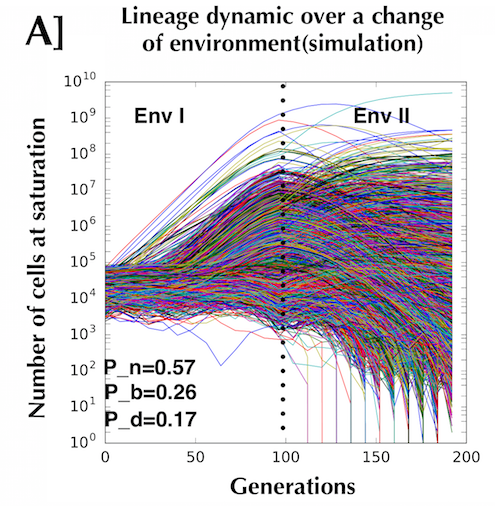

In [6]:
Image(filename='/Users/labguest/Documents/Seb/Portfolio/fig/FigSI18_cropped.png')

$\textbf{Lineage trajectories}$ In this plot, each line represents a lineage. The simulation was done with the different probqabilities to become neutral, beneficial or deleterious upon a change of environment of : 0.57,0.26 and 0.17. Plotted from file full.txt

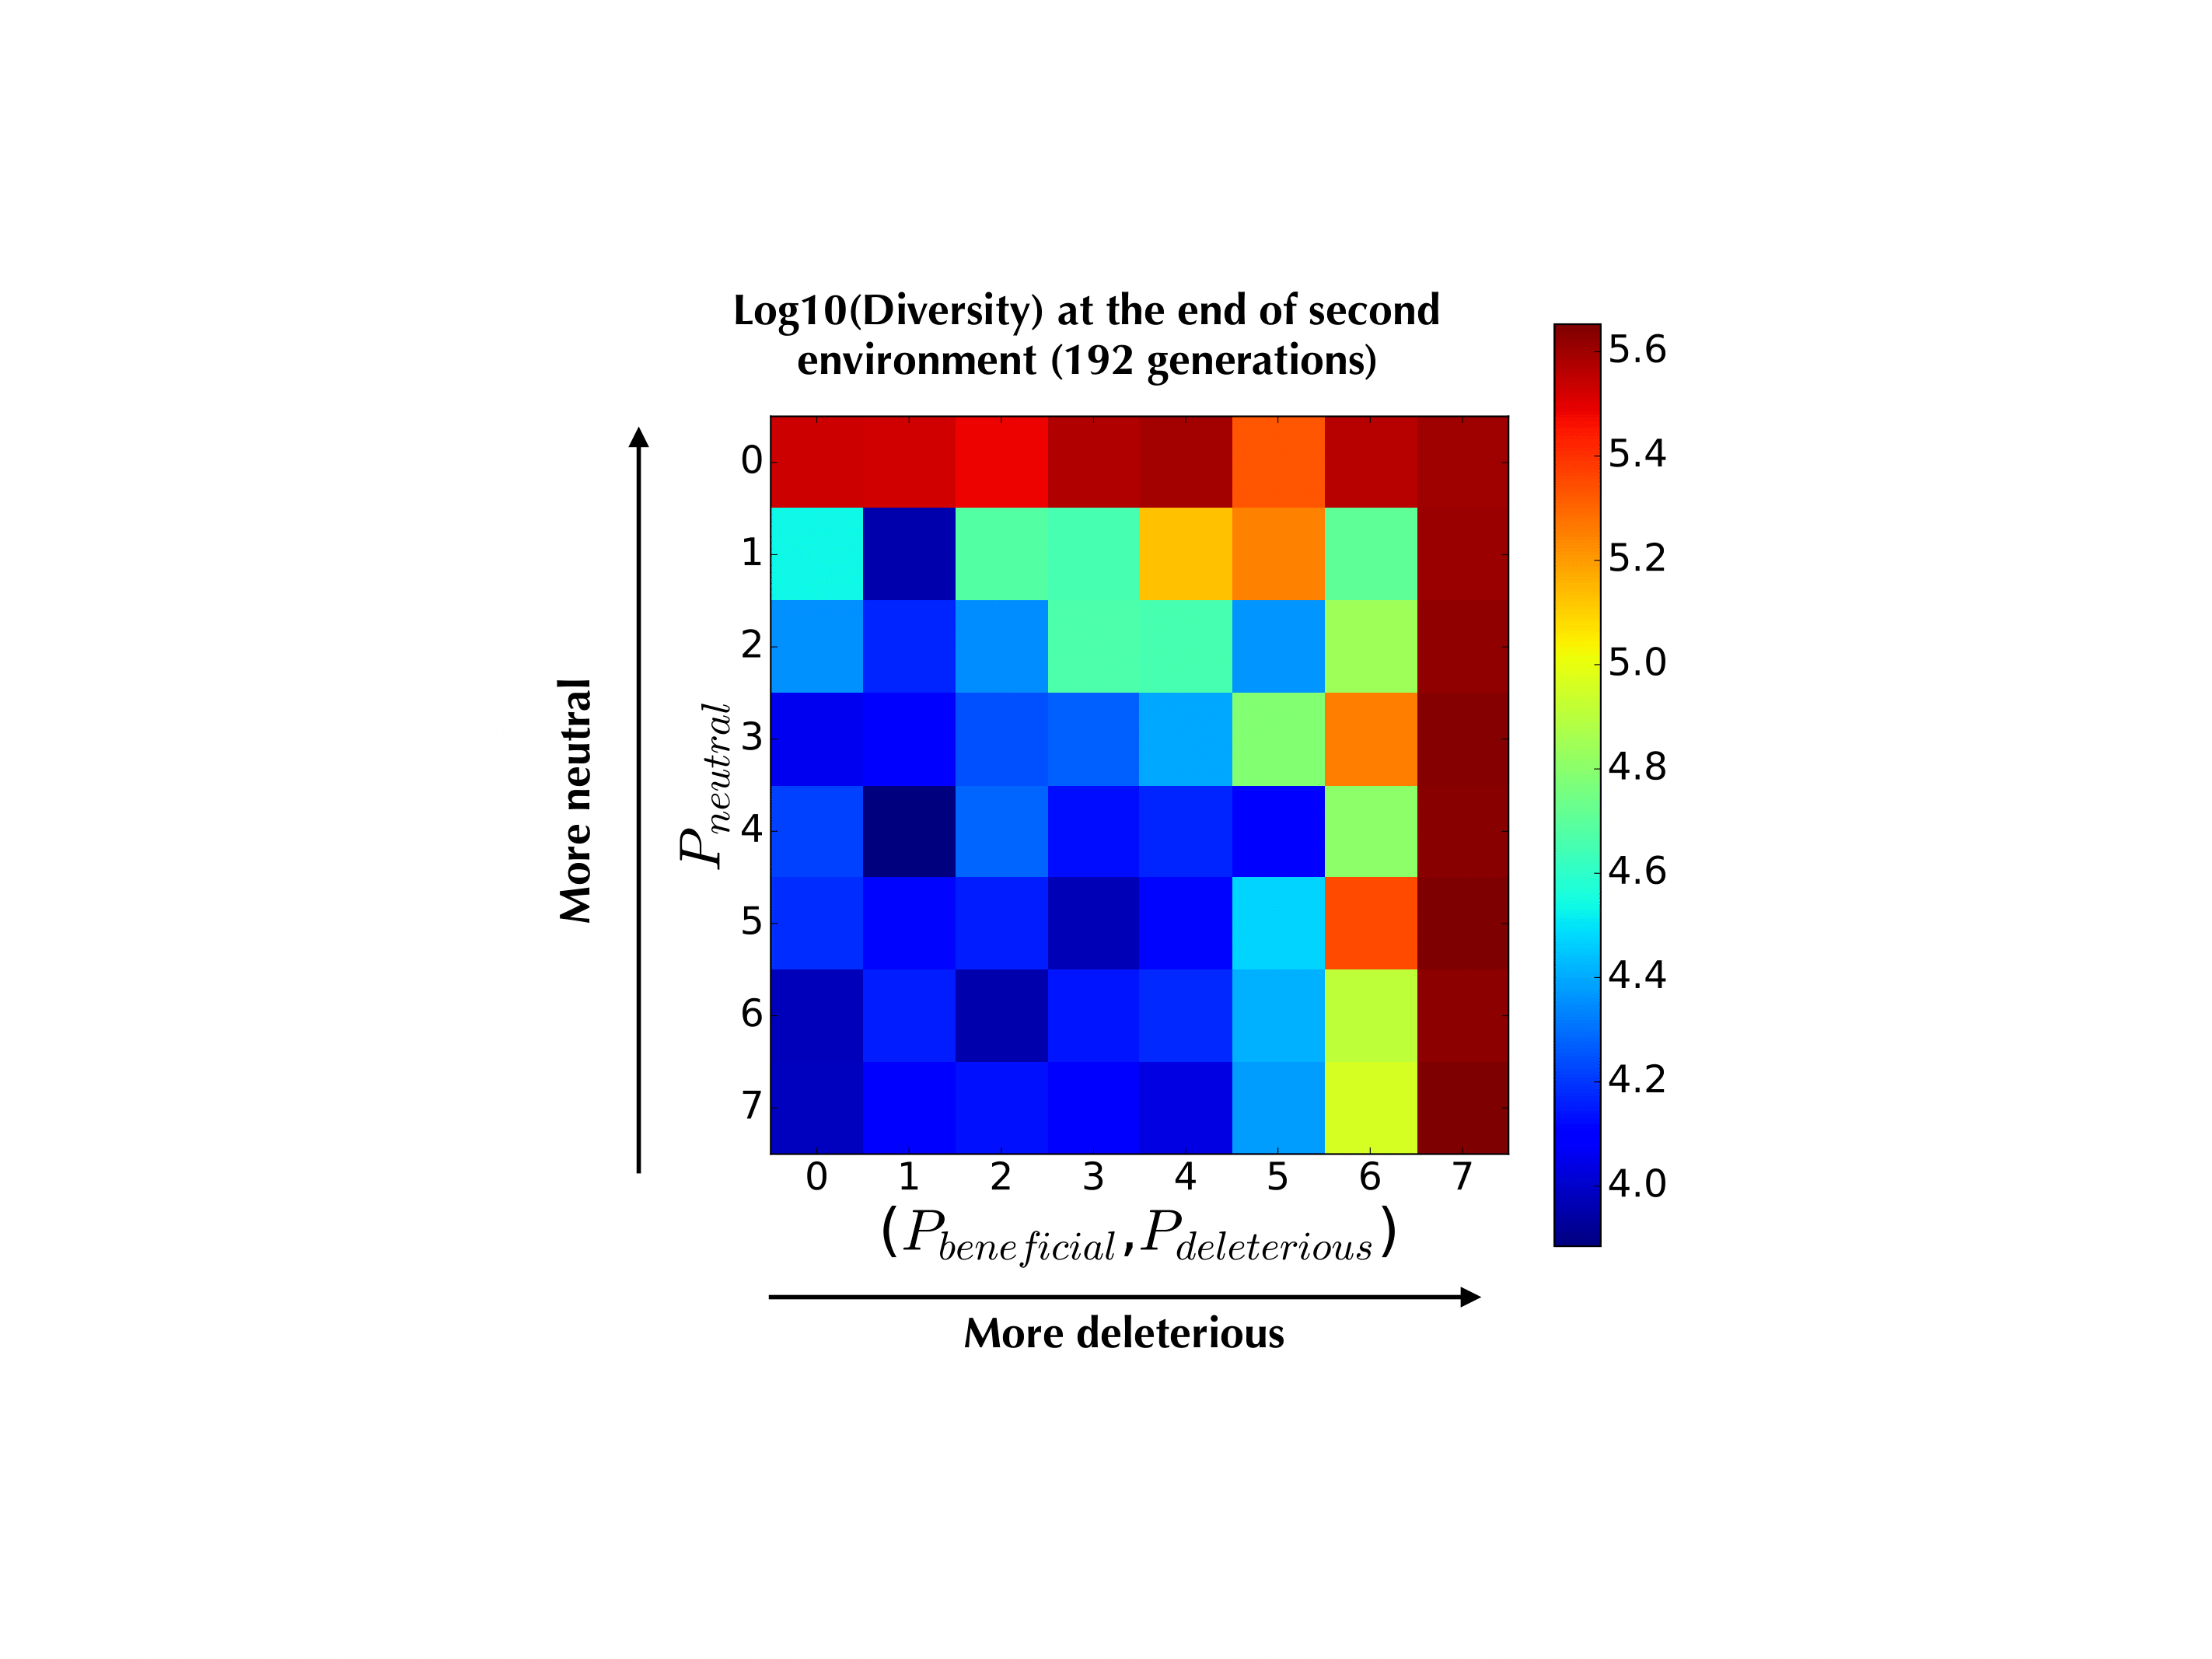

In [7]:
Image(filename='/Users/labguest/Documents/Seb/Portfolio/fig/FigSI31-1.png')

$\textbf{Simulation of barcode diversity loss after 192 generations due to uncorrelated fitness changes between two environments}$. Here, the two environments have the same uniform DFE ]0,125], non synonymous mutation rate mu_env=10^-5 and consecutive spent time of 96 generations. The initial barcode diversity is of 500 000 barcodes. Barcode diversity loss was calculated for simulation were Pn, Pb and Pd varied. There is no correlated behavior of a mutant between the two environments. We see that unless high bias toward a joint distribution of fitness effect between those two environments that links preferentially a beneficial mutation in the first environment to a deleterious or neutral fitness in the second environment, we end up with a reduction of diversity of 50 fold after 192 generations.

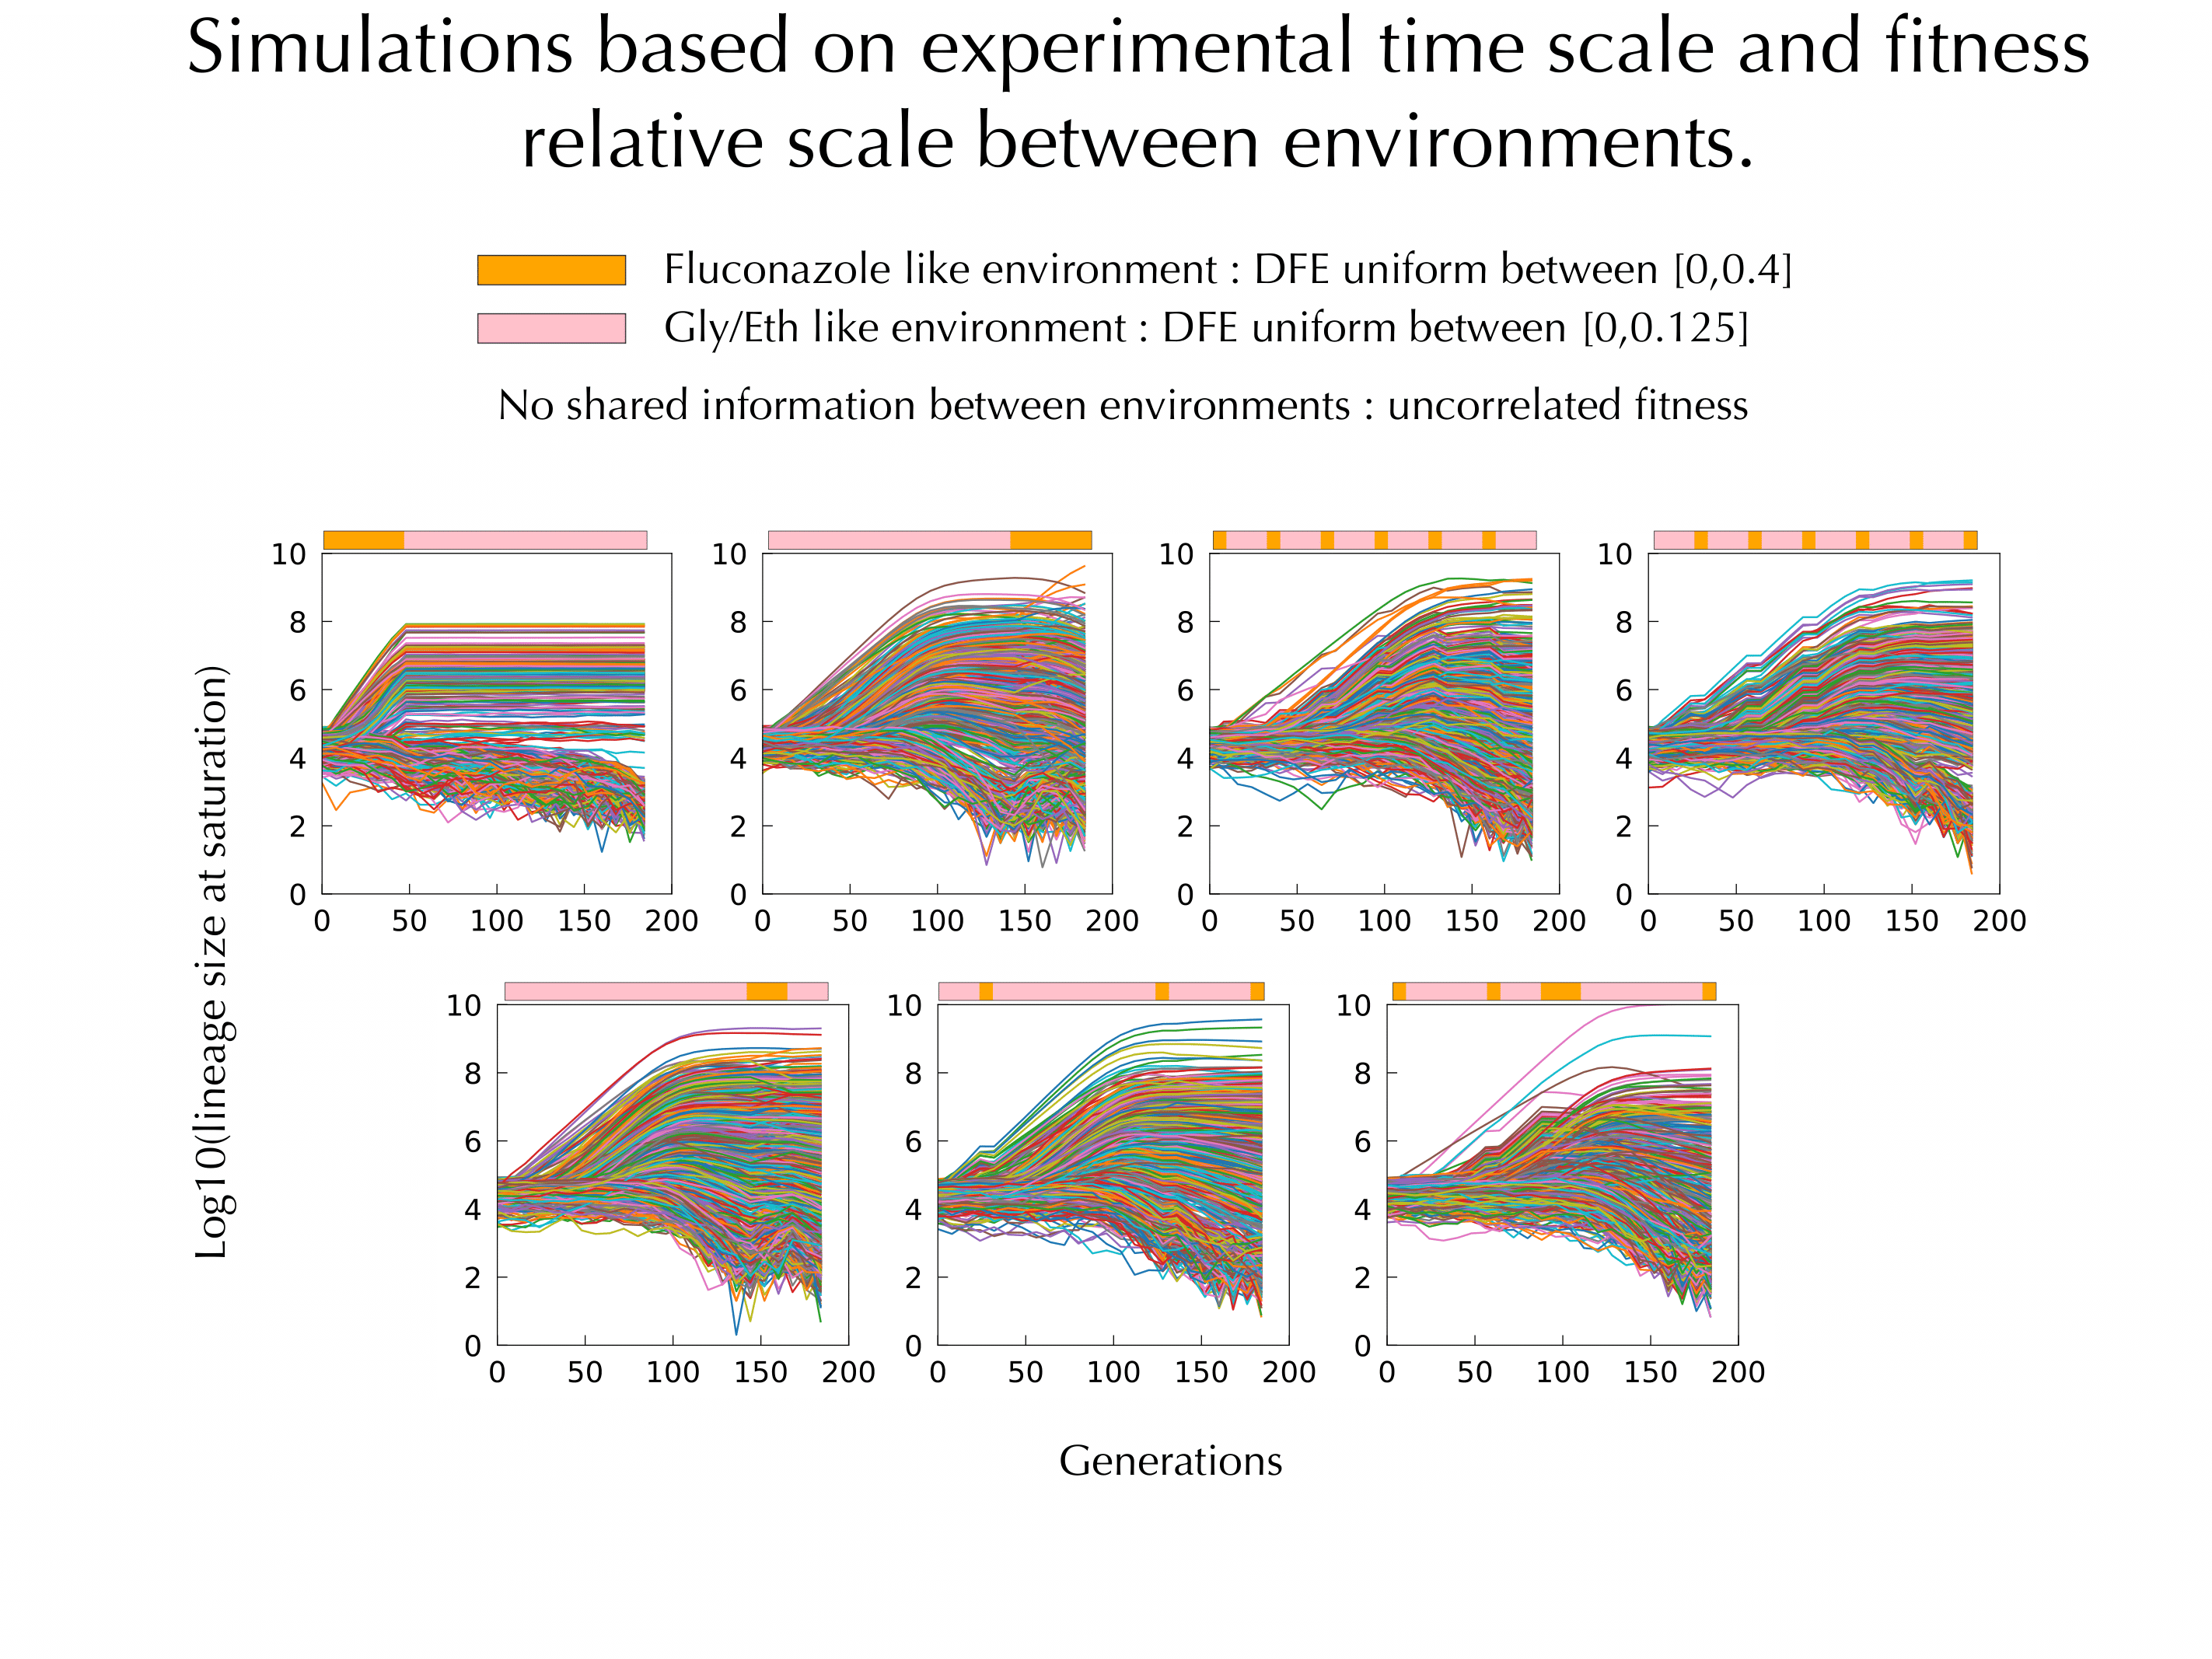

In [8]:
Image(filename='/Users/labguest/Documents/Seb/Portfolio/fig/FigSI32-1.png')

$\textbf{Lineage trajectories for sequences of environmental blocks ressembling the real experiment}$ Here the probability to be neutral in the next environment is 0.5, the probability to be deleterious is 0.25, and the probability to be beneficial is 0.25.